In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Lasso
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import (
    confusion_matrix, classification_report,
    precision_score, recall_score, f1_score,
    roc_curve, auc, RocCurveDisplay, PrecisionRecallDisplay, accuracy_score,
    ConfusionMatrixDisplay
)

In [2]:
df1 = pd.read_csv('bank-additional-full.csv', sep=';', quotechar='"')
df2 = pd.read_csv('bank-additional.csv', sep=';', quotechar='"')

## Problem

This dataset originates from the "Bank Marketing" dataset published by the Banco de Portugal (https://www.bportugal.pt/estatisticasweb). It contains client and campaign-related attributes used to predict subscription to a term deposit.

The full dataset (dataset 1) includes 41,188 rows, while a smaller validation/test dataset (dataset 2) contains 4,119 rows. The dataset features 11 categorical (object), 5 integer (int64), and 5 floating-point (float64) variables.

The target variable y is imbalanced, with approximately 90% of the observations classified as "no" (the client did not subscribe to the deposit).

The objective of this project is to build a classification model to predict whether a client will subscribe to a term deposit based on their profile and campaign data. To achieve this, I will evaluate several machine learning algorithms — including K-Nearest Neighbors, Logistic Regression, Decision Trees, and Support Vector Machines — on dataset 1. After identifying the best-performing model and its optimal hyperparameters, I will validate its performance on dataset 2.

This analysis is important for the bank to better understand which client characteristics and campaign strategies influence subscription behavior, enabling more targeted and efficient marketing efforts.

In [4]:
# Check row count, item types and column information

df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [5]:
# Drop duplicates in data set 1 & 2

df1 = df1.drop_duplicates()
df2 = df2.drop_duplicates()

In [6]:
# Identifying categorical and numerical columns

categorical_columns = df1.select_dtypes(include=['object']).columns.tolist()
numerical_columns = df1.select_dtypes(include=['float64', 'int64']).columns.tolist()

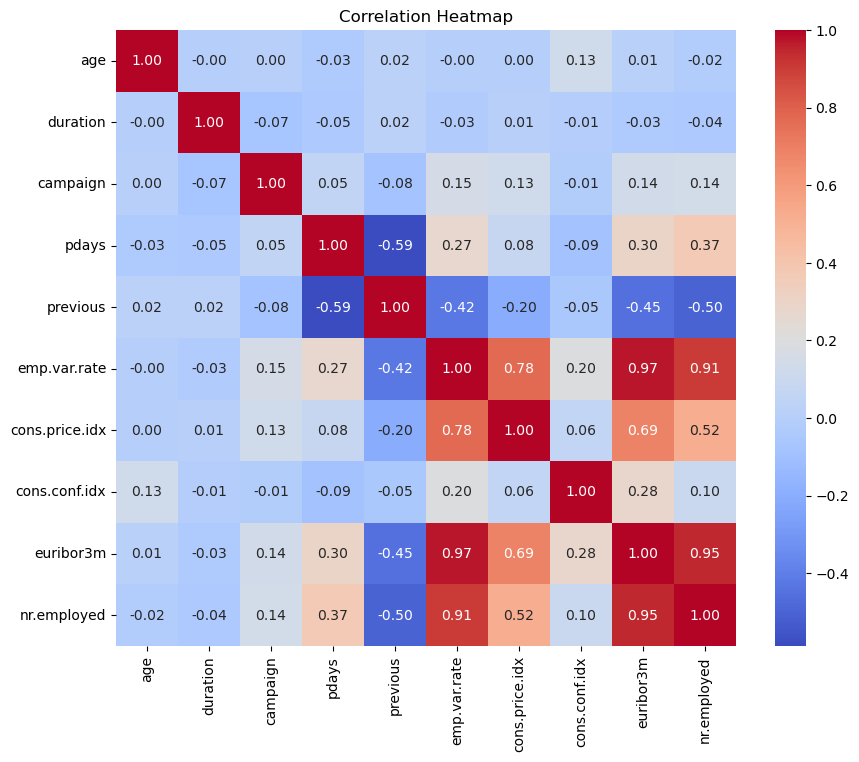

In [7]:
# As part of EDA, explore which numberical columns are correlated together, with values closer to 1 showing more correlation

corr = df1[numerical_columns].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)

plt.title('Correlation Heatmap')
plt.savefig('Correlation_Heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

In [8]:
# Define features (X) and target (y)
X = df1.drop('y', axis=1)
y = df1['y']

# Encode the target variable
le = LabelEncoder()
y = le.fit_transform(y)

# Identify  new categorical and numerical columns
categorical_columns = X.select_dtypes(include=['object']).columns.tolist()
numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns.tolist()

In [9]:
# Split the data into test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [10]:
# Build ColumnTransformer for preprocessing

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(drop='first'), categorical_columns)
    ]
)

# Create a dictionary of models and hyperparameter grids for tuning with GridSearchCV

models = {
    'knn': (KNeighborsClassifier(), {'knn__n_neighbors': [3, 5, 7]}),
    'logisticregression': (LogisticRegression(max_iter=1000), {'logisticregression__C': [0.1, 1, 10]}),
    'svc': (SVC(), {'svc__C': [0.1, 1, 10], 'svc__kernel': ['linear', 'rbf']}),
    'decisiontreeclassifier': (DecisionTreeClassifier(), {'decisiontreeclassifier__max_depth': [5, 10, 15]})}

In [11]:
# Create for loop to test 4 models and different hyperparameters

results = []

for name, (model, params) in models.items():
    # Create a pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        (name, model)
    ])
    
    # Perform grid search
    grid_search = GridSearchCV(pipeline, param_grid=params, cv=5, n_jobs=-1)
    
    # Fit the model and time it
    start_time = time.time()
    grid_search.fit(X_train, y_train)
    fit_time = (time.time() - start_time) / len(grid_search.cv_results_['mean_fit_time'])
    
    # Get the best estimator
    best_model = grid_search.best_estimator_
    
    # Evaluate on training and test sets
    train_score = best_model.score(X_train, y_train)
    test_score = best_model.score(X_test, y_test)

    # Predictions and metrics
    y_pred = best_model.predict(X_test)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    # Append the results
    results.append([name, train_score, test_score, fit_time, precision, recall, f1])

# Create the results DataFrame
results_df = pd.DataFrame(results, columns=['model', 'train score', 'test score', 'average fit time', 'precision', 'recall', 'f1'])
results_df.set_index('model', inplace=True)

# Print train & test score, average fit time, prcision, recall and f1
results_df


,train score,test score,average fit time,precision,recall,f1
model,,,,,,
knn,0.924401,0.900753,1.551315,0.600202,0.416433,0.491708
logisticregression,0.912639,0.907067,0.401016,0.660839,0.398174,0.496933
svc,0.923325,0.909334,13.453530,0.674713,0.412219,0.511770
decisiontreeclassifier,0.918329,0.912005,0.348053,0.664070,0.478933,0.556508


In [12]:
#Identify best model, hyperparameters and score

print("Best Params:", grid_search.best_params_)
print("Best Score:", round(grid_search.best_score_*100,1),"%")

Best Params: {'decisiontreeclassifier__max_depth': 5}
Best Score: 91.4 %


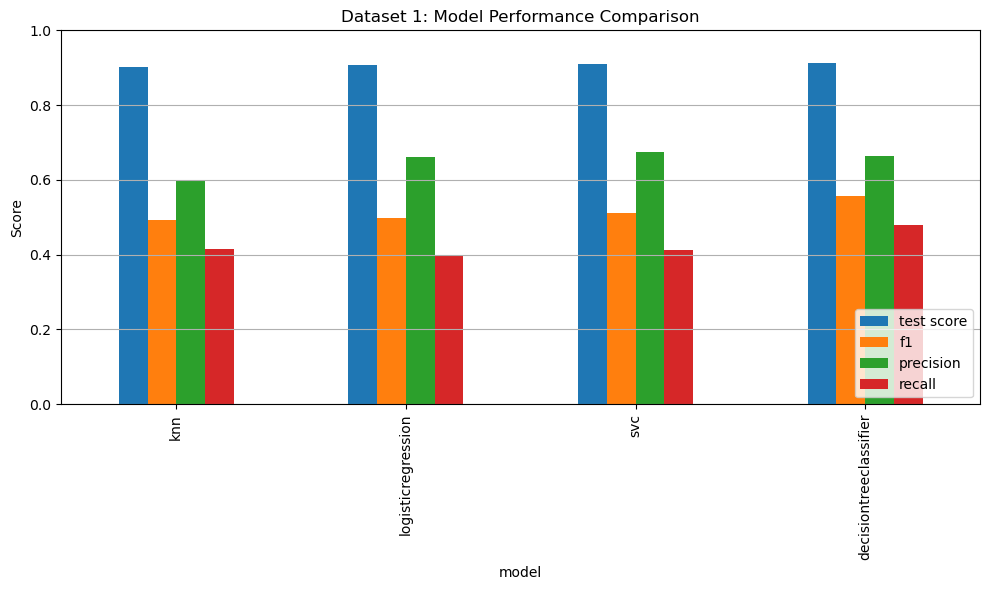

In [13]:
# Compare test score, f1, precision and recall of the four models

results_df[['test score', 'f1', 'precision', 'recall']].plot(kind='bar', figsize=(10, 6))
plt.title('Dataset 1: Model Performance Comparison')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('Model_Performance_Comparison.png', dpi=300, bbox_inches='tight')
plt.show()

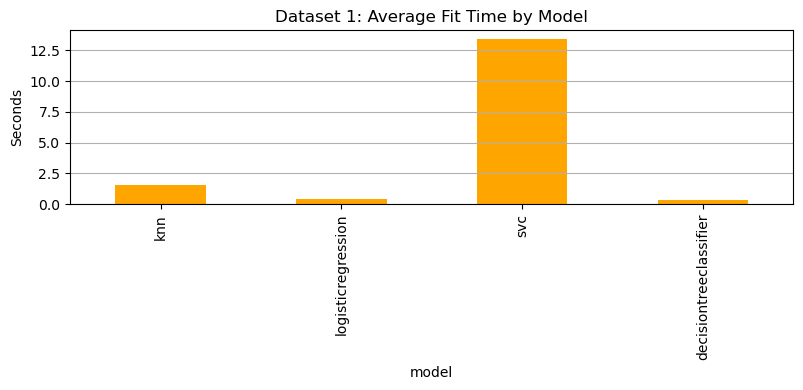

In [14]:
# Compare average fit time by model

results_df['average fit time'].plot(kind='bar', color='orange', figsize=(8, 4))
plt.title('Dataset 1: Average Fit Time by Model')
plt.ylabel('Seconds')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('Average_fit_time_by_model.png', dpi=300, bbox_inches='tight')
plt.show()

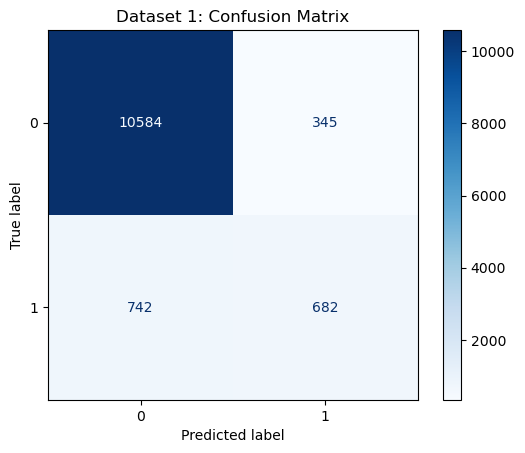

In [15]:
# Confusion matrix for best model and hyperparameters

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, labels=[0,1], cmap='Blues')
plt.title('Dataset 1: Confusion Matrix')
plt.savefig('Confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

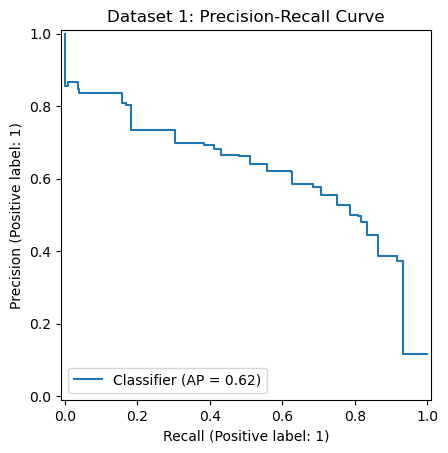

In [16]:
# Predict probabilities
y_scores = best_model.predict_proba(X_test)[:, 1] 

# Plot precision-recall
PrecisionRecallDisplay.from_predictions(y_test, y_scores)
plt.title('Dataset 1: Precision-Recall Curve')
plt.savefig('precision_recall.png', dpi=300, bbox_inches='tight')
plt.show()

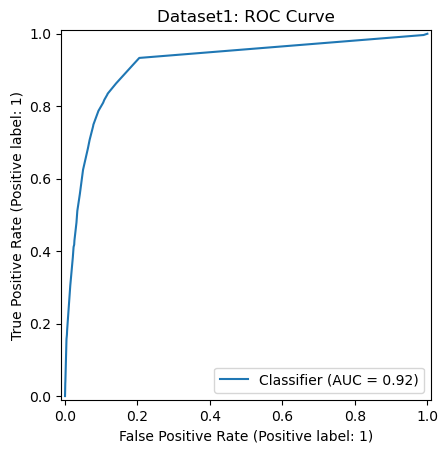

In [17]:
# Generate ROC Curve

RocCurveDisplay.from_predictions(y_test, y_scores)
plt.title('Dataset1: ROC Curve')
plt.savefig('ROC_curve.png', dpi=300, bbox_inches='tight')
plt.show()


# Analysis of Dataset 1

After evaluating Dataset 1 using four classification models—K-Nearest Neighbors (KNN), Logistic Regression, Decision Tree, and Support Vector Machine (SVC)—the Decision Tree classifier with a maximum depth of 5 was determined to be the best-performing model.

Performance metrics across all models showed consistent training and test scores, indicating minimal overfitting. While average training times were similar for most models, SVC had the highest runtime (12.51 seconds), and Logistic Regression was the fastest (0.399 seconds).

Among the four models, the Decision Tree achieved the highest F1 score, making it the most balanced model in terms of precision and recall. SVC performed well, but that did not offset the training time required vs the decision tree

# Next Steps

The next step is to evaluate the performance of the Decision Tree model on Dataset 2, a smaller dataset. This will help determine how well the model generalizes to new, unseen data.

In [19]:
# Create new target dataframes and series

X_new = df2.drop('y', axis=1)
y_new = df2['y']

# Encode the target variable
y_new = le.fit_transform(y_new)

# Predict target value using best model and hyperparameters from dataset 1
y_pred = best_model.predict(X_new)

print("Dataset 2 Accuracy:", round(accuracy_score(y_new, y_pred)*100,1),"%")
print("Dataset 2 Precision:", round(precision_score(y_new, y_pred)*100,1),"%")
print("Dataset 2 Recall:", round(recall_score(y_new, y_pred)*100,1),"%")
print("Dataset 2 F1:", round(f1_score(y_new, y_pred)*100,1),"%")

Dataset 2 Accuracy: 92.0 %
Dataset 2 Precision: 68.2 %
Dataset 2 Recall: 50.8 %
Dataset 2 F1: 58.2 %


# Dataset 2 analysis

When applied to Dataset 2, the model maintained relatively high accuracy. However, to better understand performance across different metrics (such as precision, recall, and F1 score), it is necessary to evaluate each model individually. Additionally, several hyperparameters were excluded from the initial GridSearch due to time constraints and will now be explored in a more focused manner.

# Next Steps

The next step is to individually re-evaluate each model with expanded hyperparameter tuning. This will help determine whether performance on Dataset 2 can be improved, particularly in terms of balancing false positives and false negatives.

In [21]:
# Test dataset 2 using decision tree model


pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('decisiontreeclassifier', DecisionTreeClassifier())
])

param_grid = {
    'decisiontreeclassifier__max_depth': [5, 10, 15],
    'decisiontreeclassifier__criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Dataset 1 Best Params:", grid_search.best_params_)
print("Dataset 1 Best score:", round(grid_search.best_score_*100,1),"%")

y_pred = grid_search.best_estimator_.predict(X_new)

print("Dataset 2 Accuracy:", round(accuracy_score(y_new, y_pred)*100,1),"%")
print("Dataset 2 Precision:",  round(precision_score(y_new, y_pred)*100,1),"%")
print("Dataset 2 Recall:",  round(recall_score(y_new, y_pred)*100,1),"%")
print("Dataset 2 F1:",  round(f1_score(y_new, y_pred)*100,1),"%")

Dataset 1 Best Params: {'decisiontreeclassifier__criterion': 'gini', 'decisiontreeclassifier__max_depth': 5}
Dataset 1 Best score: 91.4 %
Dataset 2 Accuracy: 92.0 %
Dataset 2 Precision: 68.2 %
Dataset 2 Recall: 50.8 %
Dataset 2 F1: 58.2 %


In [22]:
# Test dataset 2 using logistic regresssion model

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('logisticregression', LogisticRegression(random_state=42))
])

param_grid = {
    'logisticregression__penalty': ['l1', 'l2'],
    'logisticregression__C': [0.01, 0.1, 1, 10, 100],  
    'logisticregression__solver': ['liblinear'],
    'logisticregression__max_iter': [100, 500, 1000]
}

grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Dataset 1 Best Params:", grid_search.best_params_)
print("Dataset 1 Best score:", round(grid_search.best_score_*100,1),"%")

y_pred = grid_search.best_estimator_.predict(X_new)

print("Dataset 2 Accuracy:", round(accuracy_score(y_new, y_pred)*100,1),"%")
print("Dataset 2 Precision:",  round(precision_score(y_new, y_pred)*100,1),"%")
print("Dataset 2 Recall:",  round(recall_score(y_new, y_pred)*100,1),"%")
print("Dataset 2 F1:",  round(f1_score(y_new, y_pred)*100,1),"%")

Dataset 1 Best Params: {'logisticregression__C': 0.1, 'logisticregression__max_iter': 100, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}
Dataset 1 Best score: 91.2 %
Dataset 2 Accuracy: 91.5 %
Dataset 2 Precision: 68.3 %
Dataset 2 Recall: 42.1 %
Dataset 2 F1: 52.1 %


In [23]:
# Test dataset 2 using KNN model

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('knn', KNeighborsClassifier())
])

param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9, 11],
    'knn__weights': ['uniform', 'distance']
}

grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Dataset 1 Best Params:", grid_search.best_params_)
print("Dataset 1 Best score:", round(grid_search.best_score_*100,1),"%")

y_pred = grid_search.best_estimator_.predict(X_new)

print("Dataset 2 Accuracy:", round(accuracy_score(y_new, y_pred)*100,1),"%")
print("Dataset 2 Precision:",  round(precision_score(y_new, y_pred)*100,1),"%")
print("Dataset 2 Recall:",  round(recall_score(y_new, y_pred)*100,1),"%")
print("Dataset 2 F1:",  round(f1_score(y_new, y_pred)*100,1),"%")


Dataset 1 Best Params: {'knn__n_neighbors': 11, 'knn__weights': 'uniform'}
Dataset 1 Best score: 90.6 %
Dataset 2 Accuracy: 91.8 %
Dataset 2 Precision: 68.5 %
Dataset 2 Recall: 46.3 %
Dataset 2 F1: 55.3 %


In [24]:
# Test dataset 2 using SVC model

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('svc', SVC())
])

param_grid = {
    'svc__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'svc__C': [0.1, 1, 10, 100],
    'svc__gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1, 10]
}

grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Dataset 1 Best Params:", grid_search.best_params_)
print("Dataset 1 Best score:", round(grid_search.best_score_*100,1),"%")

y_pred = grid_search.best_estimator_.predict(X_new)

print("Dataset 2 Accuracy:", round(accuracy_score(y_new, y_pred)*100,1),"%")
print("Dataset 2 Precision:",  round(precision_score(y_new, y_pred)*100,1),"%")
print("Dataset 2 Recall:",  round(recall_score(y_new, y_pred)*100,1),"%")
print("Dataset 2 F1:",  round(f1_score(y_new, y_pred)*100,1),"%")

Dataset 1 Best Params: {'svc__C': 1, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}
Dataset 1 Best score: 91.2 %
Dataset 2 Accuracy: 92.3 %
Dataset 2 Precision: 75.7 %
Dataset 2 Recall: 44.1 %
Dataset 2 F1: 55.7 %


# Conclusion

Based on the analysis of Datasets 1 and 2, the Support Vector Classifier (SVC) with hyperparameters {'svc__C': 1, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'} was identified as the most effective model. 

kernal = rbf (radial basis function), to map inputs
C = 1, regulirzation parameter. Low C more tolerant of misclassified training examples, high C less tolerant of misclassified training examples
Gamma = scale, default value, small gamma means more influence from distant points, large gamme, less influence from distant points

Among the four models evaluated — K-Nearest Neighbors, Logistic Regression, Decision Tree, and SVC — the SVC achieved the highest precision on the new data, making it the best choice for this classification task. While its training time was longer compared to the others, it maintained comparable train and test accuracy and outperformed all other models in precision, which is a key metric for this business case. In dataset 1, SVC performed similar to decision tree, but took much longer to run. In dataset 2, SVC outperformed decision tree on the new data in the metrics that matter (i.e. precision), and was comparable in the other metrics.

In marketing applications like this, where the goal is to target clients most likely to subscribe to a term deposit, high precision is essential. A higher precision means fewer false positives — that is, fewer customers incorrectly identified as likely to subscribe. This reduces wasted marketing efforts and improves campaign efficiency.

Although the Decision Tree model had the best F1 score and fastest training time, the SVC's higher precision ultimately makes it the better choice when the goal is to accurately identify high-potential clients, even if it requires more computation time.

# Next Steps

Collect more representative data: Expanding the dataset can help improve model generalization and performance, especially for the minority class.

Fine-tune hyperparameters: Further hyperparameter optimization can improve performance on new or imbalanced data.

Evaluate business impact: Reducing false positives and false negatives directly supports marketing efficiency, helping the bank better target potential clients for term deposits and lower customer acquisition costs.